In [1]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import build_model
import sample
import visualization

In [10]:
model_he = build_model.make_1d_model(build_model.init_he_normal)
optimizer_he = torch.optim.Adam(model_he.parameters(), lr=0.001)

model_rai = build_model.make_1d_model(build_model.init_rai)
optimizer_rai = torch.optim.Adam(model_rai.parameters(), lr=0.001)

true_fn = sample.f1
n_epochs = 100
model_path = './output/model.obj'
x_range = (-np.sqrt(3), np.sqrt(3))

In [12]:
def train(model, true_fn, n_epochs, optimizer):
    criterion = torch.nn.MSELoss()
    x, y = sample.sample_1d(true_fn)
    x = np.expand_dims(x, 1)
    y = np.expand_dims(y, 1)

    tensor_x = torch.tensor(x, dtype=torch.float)
    tensor_y = torch.tensor(y, dtype=torch.float)
    dataloader = DataLoader(TensorDataset(tensor_x, tensor_y), 
                            batch_size=100,
                            shuffle=True)

    for epoch in range(n_epochs):
        for features, targets in dataloader:  # Trainloader will be the training dataset
            optimizer.zero_grad()
            y_pred = model(features)
            loss = criterion(y_pred, targets)
            loss.backward()
            optimizer.step()
    
    return model

In [13]:
model_rai = train(model_rai, true_fn, n_epochs, optimizer_rai)
model_he = train(model_he, true_fn, n_epochs, optimizer_he)

print("Finished Training")

Finished Training


In [14]:
def check_dead(model, x_range, resolution):
    x_samples = torch.linspace(x_range[0], x_range[1], resolution)
    pred = model(x_samples.view(-1, 1)).detach()
    return torch.allclose(pred, pred[0])

In [15]:
check_dead(model_he, x_range, 10)

True

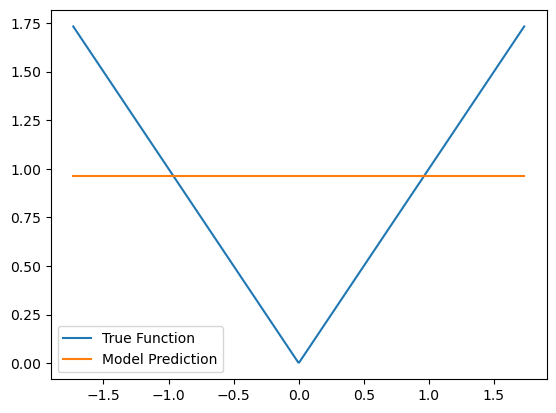

In [16]:
x_samples = torch.linspace(x_range[0], x_range[1], 500)
visualization.visualize(true_fn, model_he, x_samples)

In [18]:
def he_stats(true_fn, x_range, repetitions):
    he_results = []
    for _ in range(repetitions):
        model_he = build_model.make_1d_model(build_model.init_he_normal)
        optimizer_he = torch.optim.Adam(model_he.parameters(), lr=0.001)
        model_he = train(model_he, true_fn, n_epochs, optimizer_he)
        he_results.append(check_dead(model_he, x_range, 10))
    return sum(he_results) / len(he_results)

In [19]:
def rai_stats(true_fn, x_range, repetitions):
    rai_results = []
    for _ in range(repetitions):
        model_rai = build_model.make_1d_model(build_model.init_rai)
        optimizer_rai = torch.optim.Adam(model_rai.parameters(), lr=0.001)
        model_rai = train(model_rai, true_fn, n_epochs, optimizer_rai)
        rai_results.append(check_dead(model_rai, x_range, 10))
    return sum(rai_results) / len(rai_results)

In [21]:
he_stats(true_fn, x_range, 100)

0.71

In [20]:
rai_stats(true_fn, x_range, 100)

0.37